## Remove seasonal trend

In [2]:
import statsmodels
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os 
import datetime as datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL
#from seasonal_spike_function import find_seasonal_and_spike

#### Import data 

In [3]:
data = pd.read_csv("../data/data_project.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index(['date'], inplace=True)

In [4]:
init_data = data[:datetime.datetime(2008,12,31)]

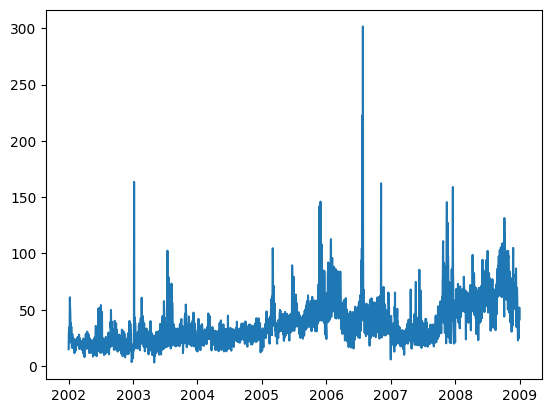

In [5]:
plt.plot(init_data)

### Multiple Seasonal-Trend decomposition

In the following, we will fit a multiple Season-Trend Decomposition. The documentation for the function can be found at [the statsmodels documentation page](https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html).  
Here are some specifications for the model introduced:  


**Trend**  
For the trend, we make a window with the length of the the entire dataspan hence in essence it is simply a linear function of time.  

**Periods**  
For the periods, we only fit polynomials of degrees 0. We fit two periods:  
1. *Weekly* period i.e. 7 days. We make the rolling window of this period be 21 days. 
2. *Yearly* period i.e. 365 days. We make a rolling window of 365 days. 


In [61]:
mstl_start = MSTL(init_data
            , periods=(7,182,365)   
            , windows =[21, 2557,2557]
            , stl_kwargs={"trend": 2557
                          ,"seasonal_deg": 0}
            ).fit()

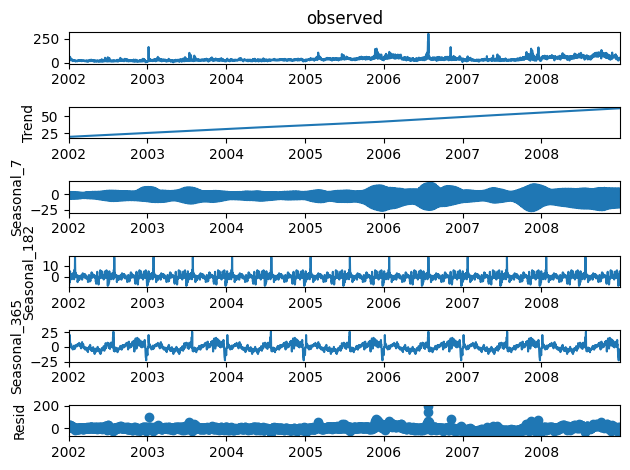

In [62]:
mstl_start.plot()
plt.show()

In [69]:
def find_seasonal_and_spike(data_input: pd.DataFrame
                            , spike_vec_input: pd.DataFrame
                            , const_rm_spike: float):
    
    data_input = data_input.copy()
    spike_vec_input = spike_vec_input.copy()
    mstl = MSTL(data_input
                , periods=(7,182,365)   
                , windows =[21, 2557,2557]
                #, periods=(7,365)   
                #, windows =[21, 365*3]
                , stl_kwargs={"trend": 2557
                              , "seasonal_deg": 0}
                ).fit()
    
    lam_vec = mstl.seasonal.sum(axis=1) + mstl.trend
    resid_vec = mstl.observed - lam_vec 
    idx_subset = resid_vec.abs() >= resid_vec.mean() + const_rm_spike * resid_vec.std()
    print(sum(idx_subset))
    if sum(idx_subset) == 0:
        return mstl, data_input, spike_vec_input, "convergence"
    
    
    spike_vec_input[idx_subset] = resid_vec[idx_subset]
    data_input[idx_subset] = (mstl.seasonal.sum(axis=1)*0.2 + mstl.trend*0.8).to_frame(name='price')
    
    return mstl, data_input, spike_vec_input, "no_converged"


In [70]:
spike_vec = pd.Series(0, index=init_data.index, dtype='float64')
mstl, data_input, spike_vec, flag_convergence = find_seasonal_and_spike(init_data, spike_vec,5)

6


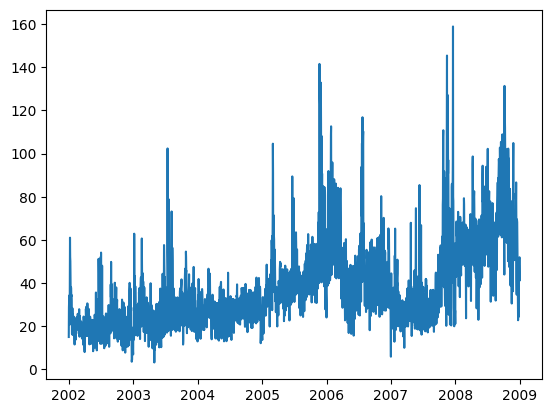

In [71]:
plt.plot(init_data - spike_vec.to_frame(name='price'))

In [72]:
mstl, data_input_2, spike_vec_2, flag_convergence = find_seasonal_and_spike(data_input, spike_vec, 1.7)
mstl = MSTL(data_input_2
                , periods=(7,182,365)   
                , windows =[21, 2557,2557]
                #, periods=(7,365)   
                #, windows =[21, 365*3]
                , stl_kwargs={"trend": 2557
                              , "seasonal_deg": 0}
                ).fit()

264


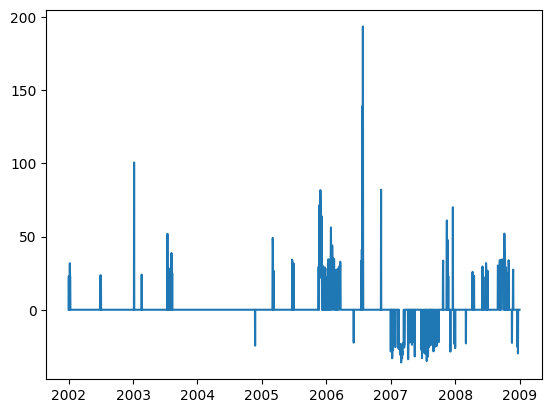

(-50.0, 200.0)

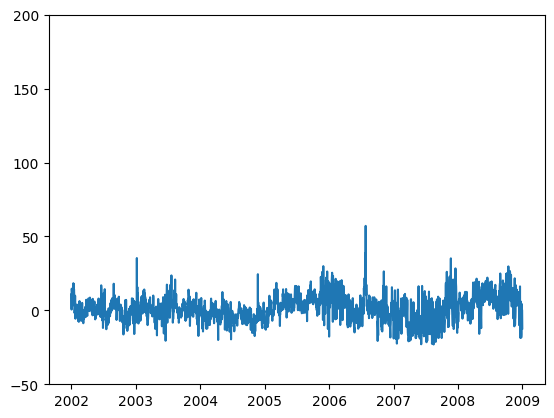

In [73]:
plt.plot(spike_vec_2)
plt.show()
plt.plot(init_data - (spike_vec_2 + mstl.seasonal.sum(axis=1) + mstl.trend).to_frame(name='price'))
plt.ylim([-50, 200])

In [29]:
def find_jump_param(spike_vec: pd.DataFrame
                    , resid_vec: pd.Series
                    , k_beta: float):

    proper_jump = pd.Series(0, index=spike_vec.index, dtype='float64')

    for i in range(1,proper_jump.shape[0]):
        if spike_vec[i] != 0:
            if spike_vec[i] > 0 and spike_vec[i] >= spike_vec[i-1]:
                proper_jump[i] = spike_vec[i]
            if spike_vec[i] < 0 and spike_vec[i] <= spike_vec[i-1]:
                proper_jump[i] = spike_vec[i]

    frequency = sum(proper_jump != 0)/len(proper_jump)
    prob_positive = sum(proper_jump > 0)/sum(proper_jump != 0)
    prob_negative =  1-prob_positive

    nu_positive = 1/proper_jump[proper_jump > 0].mean()
    nu_negative = -1/proper_jump[proper_jump < 0].mean()

    sd_resid = resid_vec.std()

    time_to_normalize = []
    resid_array = resid_vec.abs().values

    for index_i, properjump_i in enumerate(proper_jump):
        if properjump_i != 0:
            time_to_normalize.append((resid_array[index_i:]< sd_resid*k_beta).argmax())

    mean_rev_jump = 1/(sum(np.array(time_to_normalize))/len(proper_jump))

    dict_out = {'frequency': frequency
                , 'prob_positive': prob_positive
                , 'prob_negative': prob_negative
                , 'nu_positive': nu_positive
                , 'nu_negative': nu_negative
                , 'mean_rev_jump': mean_rev_jump}

    return dict_out

In [79]:
find_jump_param(spike_vec_2
                , mstl.resid
                , 0.23)

{'frequency': 0.07195932733672272,
 'prob_positive': 0.5978260869565217,
 'prob_negative': 0.40217391304347827,
 'nu_positive': 0.027772505528811012,
 'nu_negative': 0.03798778803160634,
 'mean_rev_jump': 1.0078833267638942}

### Write data to estimate the parameters of the Ornstein-Uhlenbeck process:  

In [37]:
data_out = pd.DataFrame( index=spike_vec_2.index, dtype='float64')
data_out['spike_vec'] = spike_vec_2
data_out['trend'] = mstl.trend
data_out['init_data'] = init_data
data_out = pd.concat([data_out, mstl.seasonal],axis=1)
data_out['data_estimate_brownian'] = data_out['init_data'] - \
                                        (data_out['seasonal_7']
                                         + data_out['seasonal_182']
                                         + data_out['seasonal_365']
                                         + data_out['trend']
                                         + data_out['spike_vec'])
data_out.to_csv("../data/data_for_parm_estimation_update.csv")                                    
